In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breakhis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F209316%2F999617%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240609%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240609T021934Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D31d3eef016fd095c6fc68bf92a6dc58de5a07f8efea5bce8a465a4b1b9f29065882ced410a5141703e9a7dd793e79b277c57e19f1147c9c06d1a2dd663055c160805951c8477cc2bde28bb7ba0e1463432e172ceab841edec02e22e7a80b5b111909ce4939e42d96428e9b61e774c504a33964a52cffa852b71f28dc1de73e33d9fea58a2b56d38200b96aa6d6f23d597ddc3bafafd58f5d5449e106f08033558a394300317fc01bd636b43426e372eb389815a16e4026453d0cbf882a15c102d531746ff2aedbd9ab0d30cea78829dadf6e1330c2140101facb97c3bcc06fe45c0b242d4b1502bde4bc6a38300d90d853cb8b4f5ba9338bbc31ab3aa8269af8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4278955708 bytes downloaded
Downloaded and uncompressed: breakhis
Data source import complete.


In [2]:
pip install -q cleanvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 6.4 MB/s eta 0:00:00


In [3]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from cleanvision import Imagelab
from matplotlib import ticker
from PIL import Image
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For reproducability
SEED = 51432
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Customize matplotlib graphs
plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif", size=10.5)

# Introduction

Breast cancer is the *most prevalent* form of cancer, accounting for **2,261,419** (11.7%) of the **19,292,789** cases reported worldwide in 2020 - [Global Cancer Observatory][gco].

[gco]: https://gco.iarc.fr/today/data/factsheets/cancers/39-All-cancers-fact-sheet.pdf

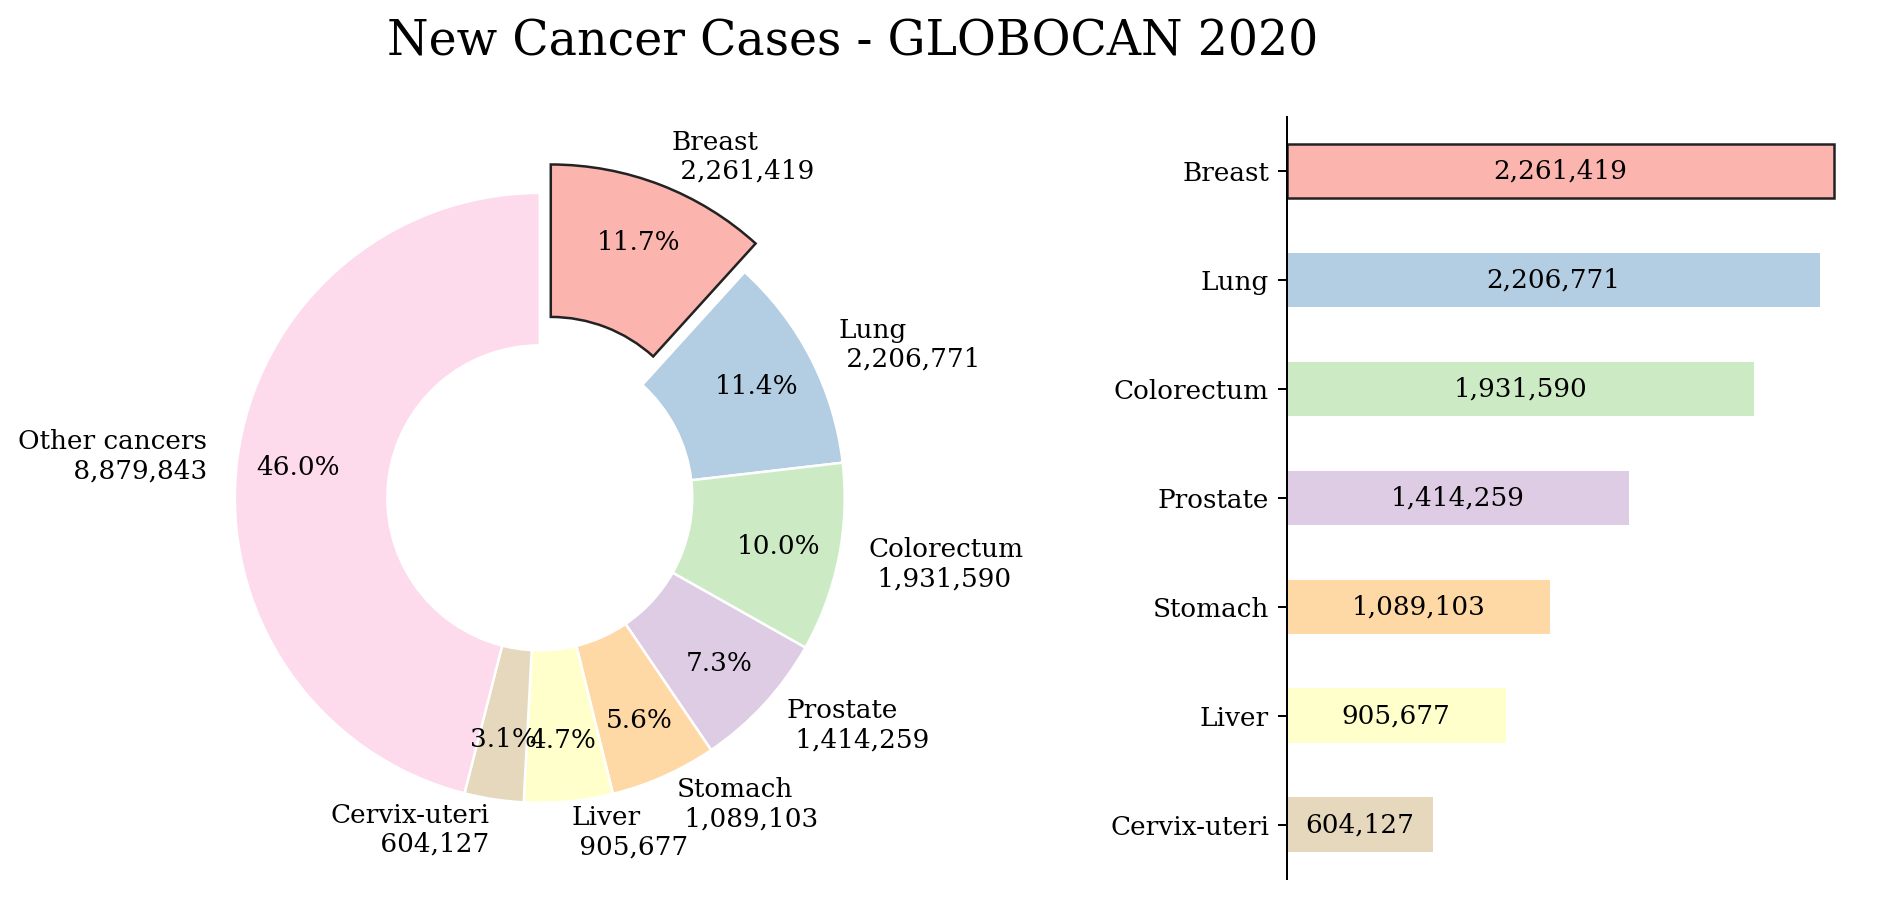

In [4]:
cancer_data = pd.Series({
    "Breast": 2261419,
    "Lung": 2206771,
    "Colorectum": 1931590,
    "Prostate": 1414259,
    "Stomach": 1089103,
    "Liver": 905677,
    "Cervix-uteri": 604127,
    "Other cancers": 8879843
})
fig, axes = plt.subplot_mosaic("aab", figsize=(14, 5.5), dpi=180)
fig.suptitle("New Cancer Cases - GLOBOCAN 2020", size=19, weight=500)
pie_chart = cancer_data.plot.pie(colors=plt.colormaps["Pastel1"].colors, startangle=90,
                                 autopct=lambda x: f"{x:.1f}%", pctdistance=0.8,
                                 explode=[0.1] + [0]*7, counterclock=False,
                                 ax=axes["a"], wedgeprops=dict(width=0.5, edgecolor='w'),
                                 labels=[f"{kind}\n {count:,}"
                                         for kind, count in cancer_data.items()])
axes["a"].axis("off")

cancer_data_specific = cancer_data.drop("Other cancers").sort_values()
bar_chart = cancer_data_specific.plot.barh(ax=axes["b"],
                                           color=plt.colormaps["Pastel1"].colors[-3:: -1])
bar_chart.bar_label(bar_chart.containers[0], [f"{x:,}" for x in cancer_data_specific],
             label_type="center"
)
axes["b"].spines["bottom"].set_visible(False)
axes["a"].patches[0].set_edgecolor("#222")
axes["b"].patches[-1].set_edgecolor("#222")
axes["b"].xaxis.set_visible(False);

Early detection of cancer is crucial in ensuring the best chances of recovery. Machine learning can enable fast, scalable diagnosis.

## Aim / Purpose

> *To create a diagnostic tool that uses computer vision models to distinguish benign breast tumours from malignant (cancerous) ones, given histopathological images.*

## Data Source

The [Breast Cancer Histopathological Database (BreakHis)][breakhis]

>Spanhol, F., Oliveira, L. S., Petitjean, C., Heutte, L., A Dataset for Breast Cancer Histopathological Image Classification, IEEE Transactions on Biomedical Engineering (TBME), 63(7):1455-1462, 2016.
>
><https://www.inf.ufpr.br/lesoliveira/download/TBME-00608-2015-R2-preprint.pdf>

The dataset consists of 7,909 microscopic images of breast tumour tissue collected from 82 patients at various magnification factors.


- Benign:
  - Adenosis (A)
  - Fibroadenoma (F)
  - Phyllodes tumour (PT)
  - Tubular adenoma (TA)
- Malignant:
  - Carcinoma (DC)
  - Lobular carcinoma (LC)
  - Mucinous carcinoma (MC)
  - Papillary carcinoma (PC)

| Magnification   |   Benign |   Malignant |   Total  |
|:----------------|---------:|------------:|---------:|
| 40X             |      652 |        1370 | **1995** |
| 100X            |      644 |        1437 | **2081** |
| 200X            |      623 |        1390 | **2013** |
| 400X            |      588 |        1232 | **1820** |
| **Total**       | **2480** |    **5429** | **7909** |

Samples were obtained via [surgical open biopsy][sob], and subjected to:

- *fixation*, *dehydration*, *clearing*, *infiltration*, *embedding*, and *trimming*
- precision *slicing* to 3μm sections using a microtome
- *staining* with hematoxylin and eosin, then covered with a glass coverslip
- *visual inspection* under a microscope by anatomopathologists to identify tumoral areas
- final *diagnosis* of each case by experienced pathologists
- confirmation by *complementary exams* such as immunohistochemistry analysis
- digital photography


[breakhis]: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/
[sob]: https://en.wikipedia.org/wiki/Breast_biopsy#Excisional_(surgical)_biopsy

# Exploratory Data Analysis

The file `Folds.csv` outlines a 5-fold cross-validation strategy which was designed such that training and test images are from different individuals:

In [5]:
fold_info = pd.read_csv("/kaggle/input/breakhis/Folds.csv")
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")
fold_info.head()

fold  mag    grp                                           filename   label
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign

Each fold contains all 7,909 available images. We will use the second fold for this study, since it has the highest proportion of training images:

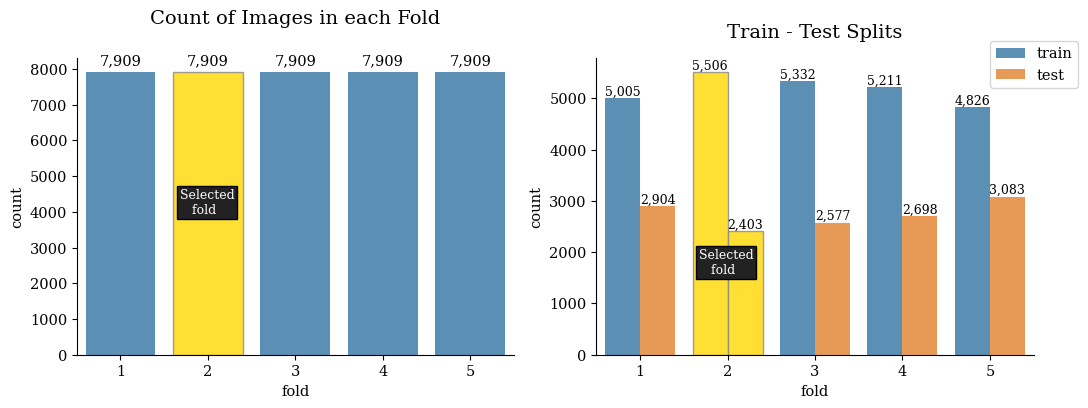

In [6]:
selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold")\
                              .copy().reset_index(drop=True)
selected_fold_data["filename"] = ("/kaggle/input/breakhis/BreaKHis_v1/"
                                  + selected_fold_data["filename"])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4.2), tight_layout=True)
# Plot image count in each fold
sb.countplot(data=fold_info, x="fold", color="C0", ax=ax1, alpha=0.8)
bars = ax1.containers[0]
ax1.bar_label(bars, padding=3,
             labels=[f"{x:,.0f}" for x in bars.datavalues])
_selected_bar = bars[selected_fold - 1]
_selected_bar.set_facecolor("gold")
_selected_bar.set_edgecolor("#888")
ax1.text(_selected_bar.get_x() + 0.08, _selected_bar.get_height() / 2,
         "Selected\n   fold", size=9, color="#fff",
         bbox={"pad": 2, "facecolor": "#222"})
ax1.set_title("Count of Images in each Fold", size=14, pad=25)

# Plot train-test split
sb.countplot(data=fold_info, x="fold", hue="grp", palette="tab10",
              ax=ax2, alpha=0.8)
for bars in ax2.containers:
    ax2.bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    bars[selected_fold - 1].set_facecolor("gold")
    bars[selected_fold - 1].set_edgecolor("#888")
ax2.text(_selected_bar.get_x() + 0.07, _selected_bar.get_height() / 5,
         "Selected\n   fold", size=9, color="#fff",
         bbox={"pad": 2, "facecolor": "#222"})
ax2.set_title("Train - Test Splits", size=14, pad=15)
ax2.legend(loc=(0.9, 0.9));

## Magnification factors

[Previous work][magnf-article],
>Ashtaiwi, A. *Optimal Histopathological Magnification Factors for Deep Learning-Based Breast Cancer Prediction*. Appl. Syst. Innov. 2022, 5, 87. https://doi.org/10.3390/asi5050087

established that training models on images with magnification factor at least **_200X_** yields the best results.

Consider the following images from slide 22549AB at different magnification factors:

[magnf-article]: https://www.mdpi.com/2571-5577/5/5/87

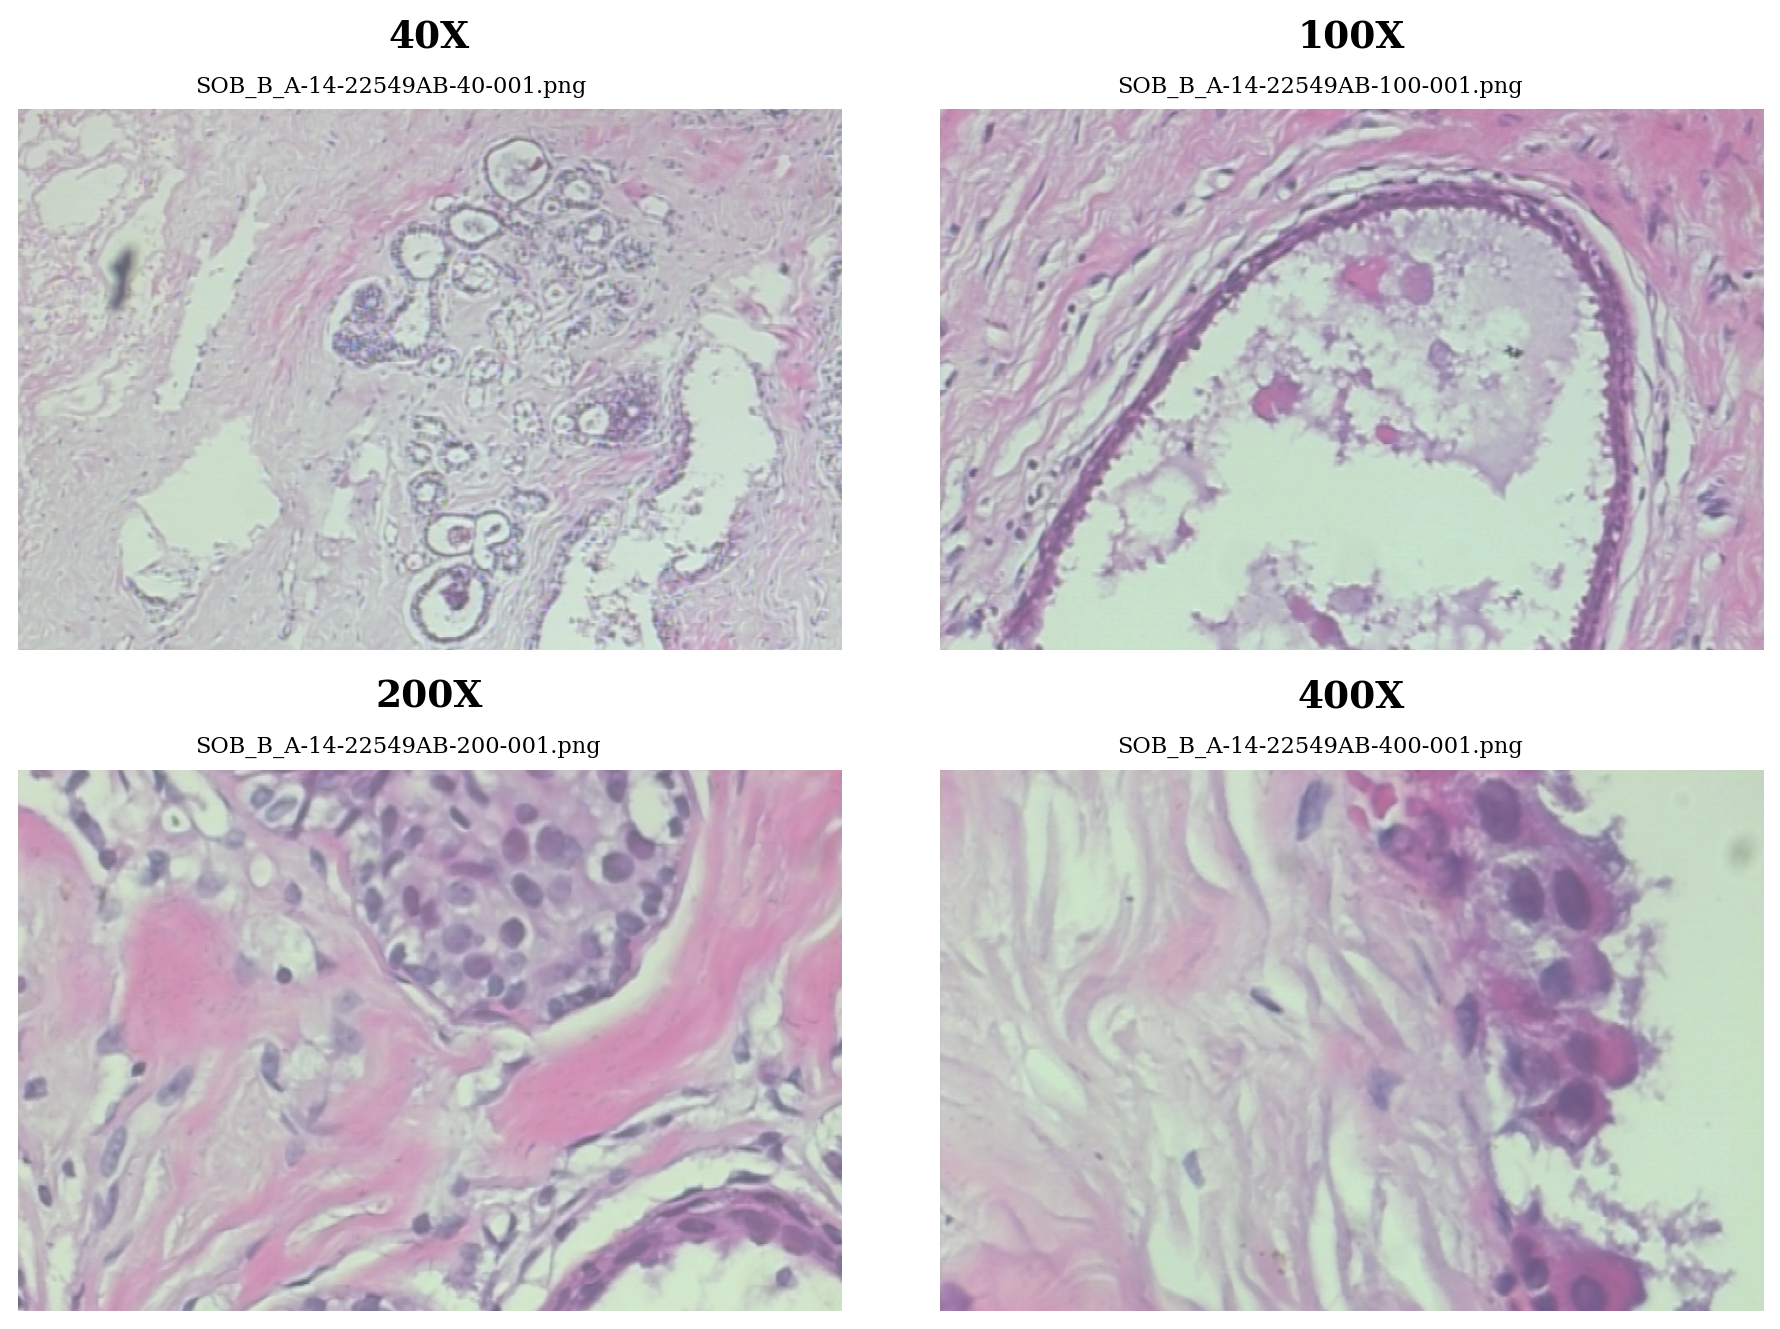

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7.5), dpi=180, tight_layout=True)
sample_images = selected_fold_data.groupby("mag", as_index=False).first()
for ax, row in zip(axes.flat, sample_images.itertuples()):
    img = Image.open(row.filename)
    ax.imshow(img)
    ax.set_title(f"{row.mag}X", size=15, pad=25, weight=600)
    ax.text(150, -15, row.filename.split("/")[-1], size=9)
    ax.axis("off")

## Image Validation

There are about 256 (3.16%) duplicate images. On inspection, duplicated pairs have similar slide-ID but different tumour types; which might suggest that those slides capture more than 1 tumour type (and perhaps also human error).

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/7909 [00:00<?, ?it/s]

  0%|          | 0/7909 [00:00<?, ?it/s]

Issue checks completed. 330 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          250 |
|  1 | odd_size         |           74 |
|  2 | near_duplicates  |            6 |
|  3 | blurry           |            0 |
|  4 | dark             |            0 |
|  5 | grayscale        |            0 |
|  6 | light            |            0 |
|  7 | low_information  |            0 |
|  8 | odd_aspect_ratio |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 250
Examples representing most severe instances of this issue:

Set: 0


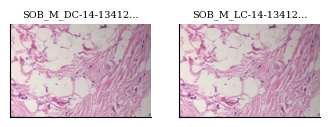

Set: 1


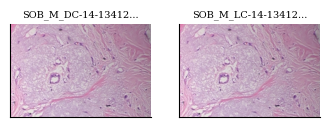

Set: 2


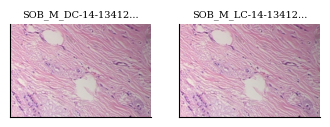

Set: 3


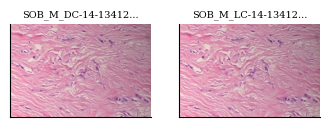

--------------------- odd_size images ----------------------

Number of examples with this issue: 74
Examples representing most severe instances of this issue:



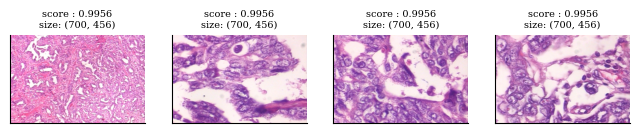

------------------ near_duplicates images ------------------

Number of examples with this issue: 6
Examples representing most severe instances of this issue:

Set: 0


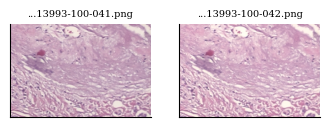

Set: 1


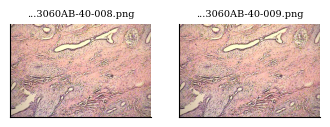

Set: 2


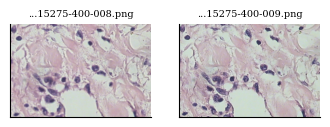

In [8]:
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()
imagelab.report(verbosity=4)

In [9]:
duplicated_images = imagelab.issues[
    ["is_exact_duplicates_issue", "is_near_duplicates_issue"]
].any(axis=1).reset_index().rename(columns={"index": "filename", 0: "duplicated"})
duplicated_images.head()

filename  duplicated
0  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...       False
1  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...       False
2  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...       False
3  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...       False
4  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...       False

In [10]:
# Check that filenames align
assert duplicated_images["filename"].equals(selected_fold_data["filename"])

# Drop all duplicated images, then validate again
selected_fold_data = selected_fold_data[~duplicated_images["duplicated"]]
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/7653 [00:00<?, ?it/s]

  0%|          | 0/7653 [00:00<?, ?it/s]

Issue checks completed. 74 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


In [11]:
# Use data in selected fold (2) with magnification factor >= 200X
train = selected_fold_data.query("mag >= 200 and grp == 'train'")
test = selected_fold_data.query("mag >= 200 and grp == 'test'")
train.shape, test.shape

((2566, 5), (1149, 5))

## Target Distribution

There are significantly more images of *malignant* cases than there are of *benign* ones:

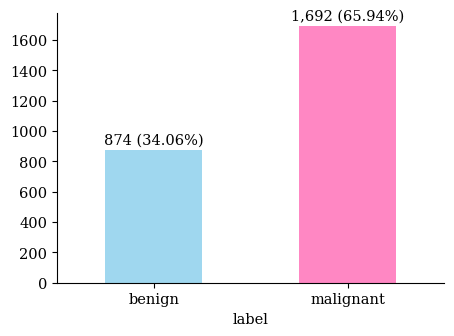

In [12]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["skyblue", "hotpink"], alpha=0.8,
                           figsize=(5, 3.5))
ax.bar_label(ax.containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0);

When there's *class imbalance* in a classification problem, accuracy is an unreliable metric; it becomes easy to achieve high accuracy by just predicting more of the majority class.

To illustrate, a classifier predicting only *malignant* (1) would get an accuracy score of 65.94% here, without ever identifying any *benign* cases. But that same model would only achieve an ROC-AUC score of 50% (random, no better than chance).

In [13]:
y = train["label"].map(classes)
positive_only_preds = np.ones_like(y)
print(f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2%}",
      f"\nROC-AUC:  {metrics.roc_auc_score(y, positive_only_preds):.2%}")

Accuracy: 65.94% 
ROC-AUC:  50.00%




We will thus use [ROC-AUC][roc] and a [confusion matrix][cmat] for model evaluation.

[cmat]: https://en.wikipedia.org/wiki/Confusion_matrix
[roc]: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

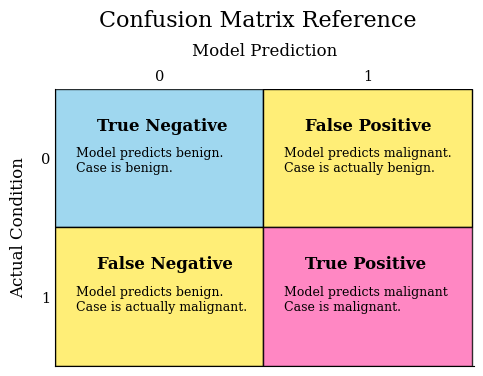

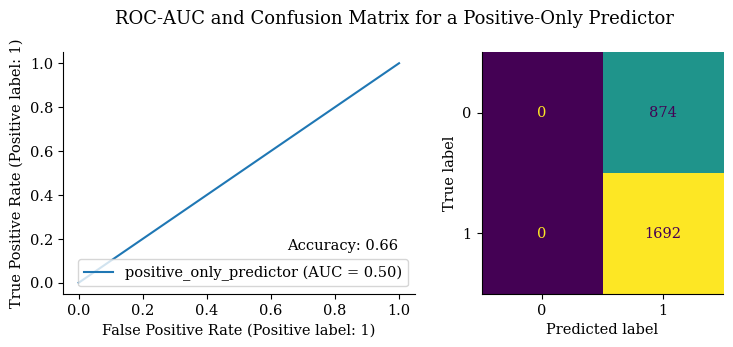

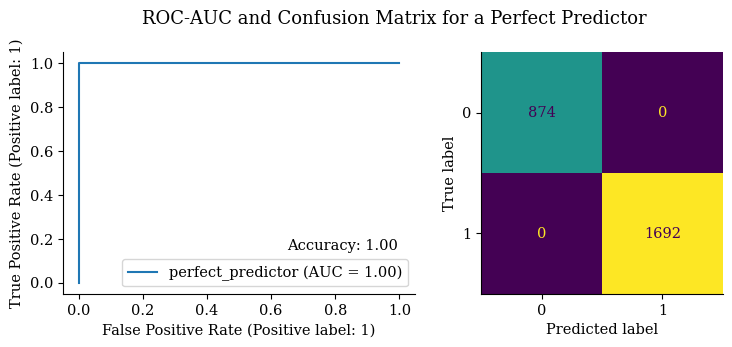

In [14]:
# Draw a confusion matrix with descriptions
fig, ax = plt.subplots(figsize=(5.4, 3.6))
ax.axvspan(0, 0.5, 0.5, 1, facecolor="skyblue", alpha=0.8, edgecolor="black")
ax.axvspan(0.5, 1, 0.5, 1, facecolor="#fe7", edgecolor="black")
ax.axvspan(0, 0.5, 0, 0.5, facecolor="#fe7", edgecolor="black")
ax.axvspan(0.5, 1, 0, 0.5, facecolor="hotpink", alpha=0.8, edgecolor="black")
ax.text(0.1, 0.85, "True Negative", size=12, weight=600)
ax.text(0.05, 0.7, "Model predicts benign.\nCase is benign.", size=9)
ax.text(0.6, 0.85, "False Positive", size=12, weight=600)
ax.text(0.55, 0.7, "Model predicts malignant.\nCase is actually benign.", size=9)
ax.text(0.1, 0.35, "False Negative", size=12, weight=600)
ax.text(0.05, 0.2, "Model predicts benign.\nCase is actually malignant.", size=9)
ax.text(0.6, 0.35, "True Positive", size=12, weight=600)
ax.text(0.55, 0.2, "Model predicts malignant\nCase is malignant.", size=9)
ax.set_xlim(0, 1.005)
ax.xaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.xaxis.set_ticklabels([0, 1])
ax.yaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.yaxis.set_ticklabels([1, 0])
ax.set_ylabel("Actual Condition", size=12, labelpad=10)
ax.set_xlabel("Model Prediction", size=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticks_position("top")
ax.spines["left"].set_position("zero")
ax.tick_params(pad=0, top=False, left=False)
fig.suptitle("Confusion Matrix Reference", y=1.1, size=16)

# Plot metrics for positive-only-predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y, positive_only_preds, ax=ax1,
                                         name="positive_only_predictor")
metrics.ConfusionMatrixDisplay.from_predictions(y, positive_only_preds,
                                                ax=ax2, colorbar=False)
ax1.text(0.65, 0.15,
         f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2f}")
fig.suptitle("ROC-AUC and Confusion Matrix for a Positive-Only Predictor", size=13)

# Plot metrics for "perfect" predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y, y, ax=ax1, name="perfect_predictor")
ax1.text(0.65, 0.15, f"Accuracy: {metrics.accuracy_score(y, y):.2f}")
metrics.ConfusionMatrixDisplay.from_predictions(y, y, ax=ax2, colorbar=False)
fig.suptitle("ROC-AUC and Confusion Matrix for a Perfect Predictor", size=13);

# Data Ingestion & Preprocessing

Images need to be converted into numeric form for consumption by computer vision models.

We'll use the [tensorflow image module][tf-image] to:

- load the PNG image files
- decode the images and convert them to 3D tensors
- resize the images to a uniform size (some have 760x460 pixels while some have 760x456).

[tf-image]: https://www.tensorflow.org/api_docs/python/tf/image

In [15]:
IMG_SIZE = 224
BATCH_SIZE = 28


def load_image(filename: str, label: int) -> Tuple[tf.Tensor, str]:
    file = tf.io.read_file(filename)
    img = tf.image.decode_png(file, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    return img, label


# Prepare training and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(
    train["filename"], train["label"].map(classes), random_state=SEED
)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
             .map(load_image).batch(BATCH_SIZE)
validation_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))\
                  .map(load_image).batch(BATCH_SIZE)
# Prepare test dataset
test = test.sample(frac=1, random_state=SEED)  # shuffle test data
test_ds = tf.data.Dataset.from_tensor_slices(
    (test["filename"], test["label"].map(classes))
).map(load_image).batch(BATCH_SIZE)

# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Let's have a look at some of the images:

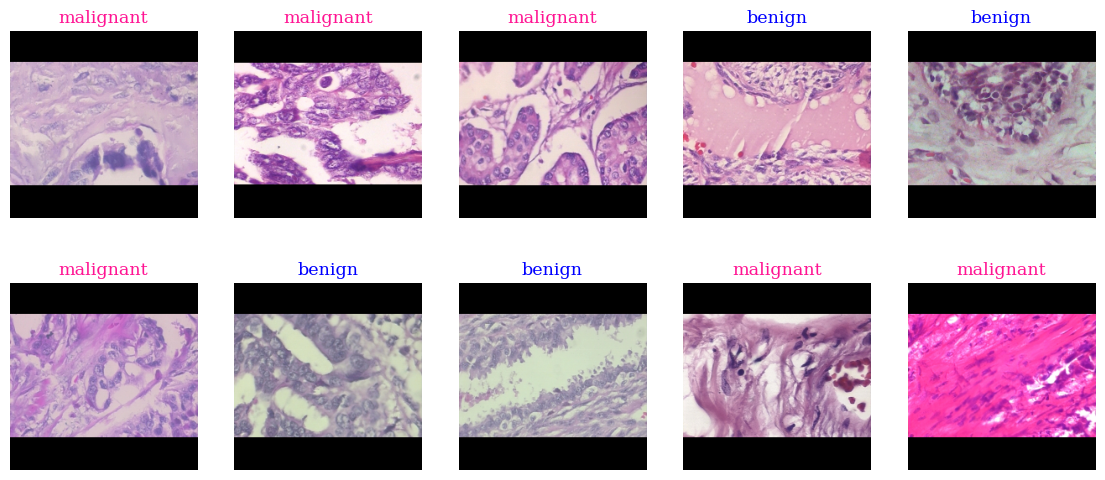

In [16]:
plt.figure(figsize=(14, 6))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        label = class_names[labels[i]]
        title_color = "blue" if label == "benign" else "deeppink"
        plt.title(class_names[labels[i]], color=title_color)
        plt.axis("off")

## Data Augmentation

[Data augmentation][data-aug] is a technique for increasing the amount of training data by adding *slightly modified copies* or new *synthetic data*.

It has the added benefit of making models robust to variations in the images. For instance, models exposed to rotated images might learn that orientation is not important when identifying cancerous cells.

Methods used here include:

1. Random brightness shifts (to help address varying light conditions).
2. Random horizontal and vertical flips (to help address different orientations).
3. Random rotations (to also help address different orientations).

[data-aug]: https://en.wikipedia.org/wiki/Data_augmentation

In [17]:
sample_image = load_image(*train[["filename", "label"]].iloc[0])[0]


def plot_augmentations(augmentation_layer: tf.keras.layers.Layer) -> None:
    augment_name = augmentation_layer.name
    fig, (ax0, *axes) = plt.subplots(ncols=4, figsize=(15, 4))
    ax0.imshow(sample_image.numpy().astype("uint8"))
    ax0.set_title("Original", size=14, pad=10)
    ax0.axis("off")
    for idx, ax in enumerate(axes):
        augmented_image = augmentation_layer(sample_image)
        ax.imshow(augmented_image.numpy().astype("uint8"))
        ax.set_title(augment_name.title(), size=14, pad=10)
        ax.axis("off")

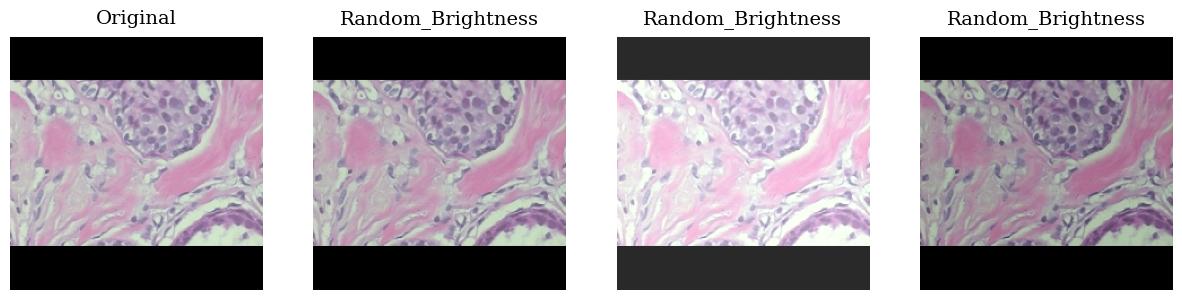

In [18]:
plot_augmentations(layers.RandomBrightness(0.2))

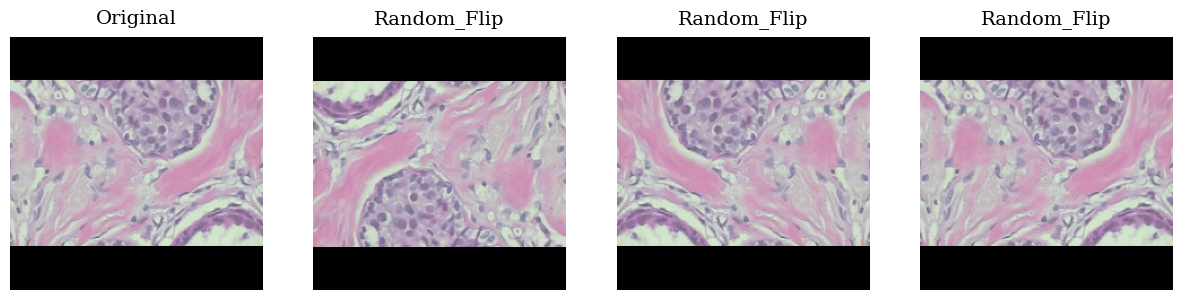

In [19]:
plot_augmentations(layers.RandomFlip())

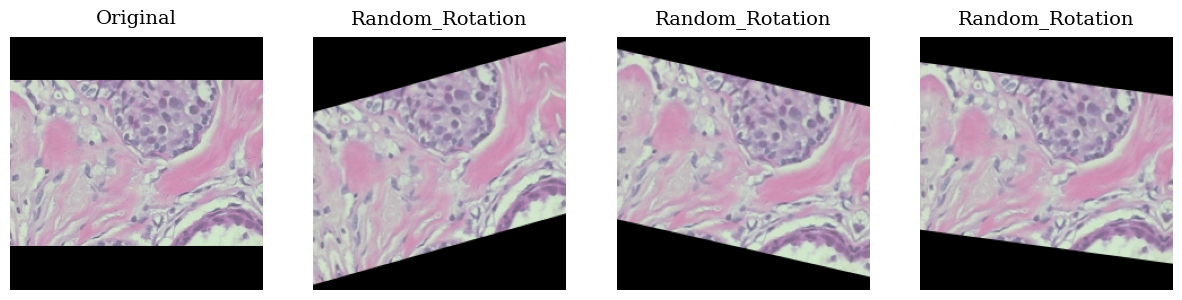

In [20]:
plot_augmentations(layers.RandomRotation(0.2, seed=SEED))

## Helper functions

In [21]:
MAX_EPOCHS = 25
BASE_LEARNING_RATE = 0.001


def compile_and_fit_model(
    model: tf.keras.Model,
    learning_rate: float=BASE_LEARNING_RATE,
    epochs: int=MAX_EPOCHS
) -> tf.keras.callbacks.History:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name="roc_auc"), "binary_accuracy"]
    )
    early_stopping = EarlyStopping(min_delta=1e-4, patience=5, verbose=1,
                                   restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, verbose=1)
    history = model.fit(train_ds, validation_data=validation_ds,
                        epochs=epochs, callbacks=[early_stopping, reduce_lr])
    # Plot training metrics
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(ncols=2, figsize=(11, 4))
    for ax, metric in zip(axes.flat, ["Accuracy", "Loss"]):
        performance_df.filter(like=metric.lower()).plot(ax=ax)
        ax.set_title(metric, size=14, pad=10)
        ax.set_xlabel("epoch")
    return history


def evaluate_model(model: tf.keras.Model, dataset: tf.data.Dataset=test_ds) -> None:
    loss, auc, accuracy = model.evaluate(dataset, verbose=0)
    print(f"\nROC-AUC:   {auc:.5f}",
          f"Accuracy:  {accuracy:.5f}",
          f"Loss:      {loss:.5f}\n", sep="\n")
    # Get labels and predictions for each batch in dataset
    results = [(labels, model.predict(images, verbose=0).reshape(-1))
               for images, labels in dataset.take(-1)]
    labels = np.concatenate([x[0] for x in results])
    preds = np.concatenate([x[1] for x in results])
    # Plot metrics
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=160)
    curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]
    for ax, curve in zip(axes[:2], curves):
        curve.from_predictions(labels, preds, ax=ax, name=model.name)
    metrics.ConfusionMatrixDisplay.from_predictions(
        labels, preds.round().astype("uint8"), ax=axes[2], colorbar=False,
    )
    titles = ["ROC-AUC Curve", "Precision-Recall Curve", "Confusion Matrix"]
    for ax, title in zip(axes.flat, titles):
        ax.set_title(title, size=14, pad=10)


def plot_predictions(model: tf.keras.Model) -> None:
    plt.figure(figsize=(14, 9))
    for images, labels in test_ds.take(1):
        labels = labels.numpy()
        predicted_labels = model.predict(images).round().astype("uint8").reshape(-1,)
        print("Predicted:", predicted_labels)
        print("Actual:   ", labels)
        for i, (pred, actual) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(4, 7, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if pred == actual:
                plt.title(class_names[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_names[predicted_labels[i]]}\n"
                          + f"(Actual: {class_names[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

# Custom Convolutional Neural Network

A [Convolutional Neural Network][cnn] (CNN) is a class of artificial neural networks that is well suited for computer vision problems. It excels at finding patterns (features) in images (see [introduction to CNNs][cnn-intro]).

[cnn]: https://en.wikipedia.org/wiki/Convolutional_neural_network
[cnn-intro]: https://www.kaggle.com/code/ryanholbrook/the-convolutional-classifier

In [22]:
custom_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # Convolutional block I
    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Convolutional block II
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Convolutional block III
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Fully connected layers
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="CustomCNN")
custom_model.summary()

Model: "CustomCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_1 (Rando  (None, 224, 224, 3)       0         
 mBrightness)                                                    
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 batch_normalization (Batch  (None, 224, 224, 3)       12        
 Normalization)                                                  
                                                         

Epoch 1/25
69/69 [==============================] - 270s 4s/step - loss: 0.5137 - roc_auc: 0.8008 - binary_accuracy: 0.7599 - val_loss: 0.4950 - val_roc_auc: 0.8680 - val_binary_accuracy: 0.8006 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - 238s 3s/step - loss: 0.4726 - roc_auc: 0.8376 - binary_accuracy: 0.8150 - val_loss: 0.4888 - val_roc_auc: 0.8739 - val_binary_accuracy: 0.7679 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - 249s 4s/step - loss: 0.4268 - roc_auc: 0.8600 - binary_accuracy: 0.8358 - val_loss: 0.4633 - val_roc_auc: 0.8847 - val_binary_accuracy: 0.7882 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - 241s 3s/step - loss: 0.4256 - roc_auc: 0.8606 - binary_accuracy: 0.8295 - val_loss: 0.4115 - val_roc_auc: 0.8764 - val_binary_accuracy: 0.8536 - lr: 0.0010
Epoch 5/25
69/69 [==============================] - 248s 4s/step - loss: 0.4363 - roc_auc: 0.8609 - binary_accuracy: 0.8093 - val_loss: 0.3816 - val_roc_auc: 0.8959 - v

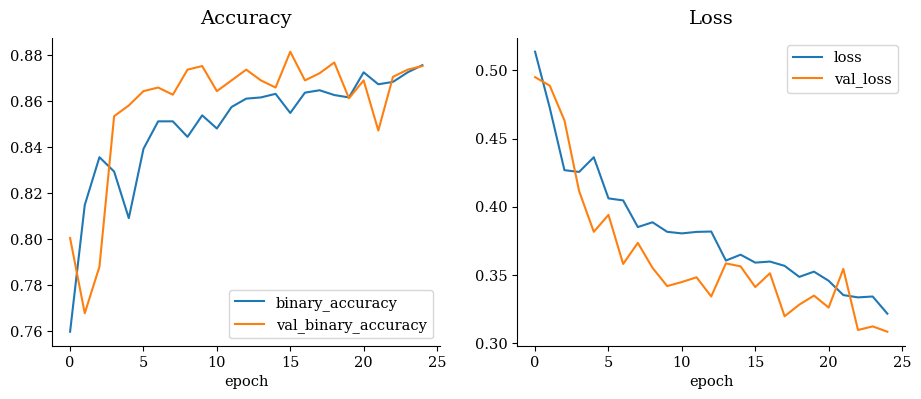

In [23]:
custom_history = compile_and_fit_model(custom_model)


ROC-AUC:   0.82237
Accuracy:  0.83029
Loss:      0.55487



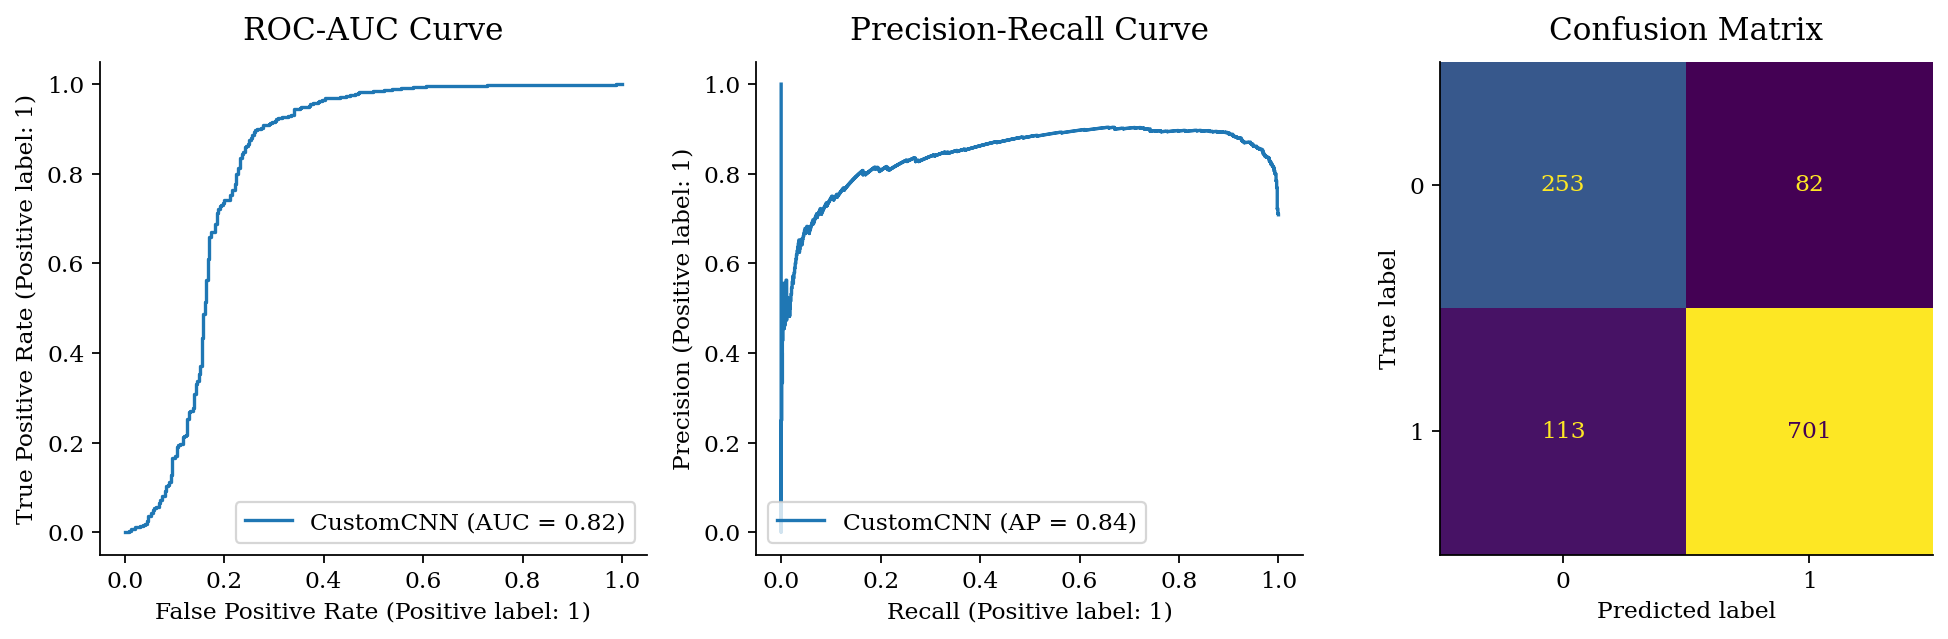

In [24]:
evaluate_model(custom_model)

The overall performance is quite good for a light-weight CNN trained on limited data. There are relatively few *false positives (86)* and *false negatives (81)*.

1/1 [==============================] - 1s 770ms/step
Predicted: [1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1]
Actual:    [1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1]


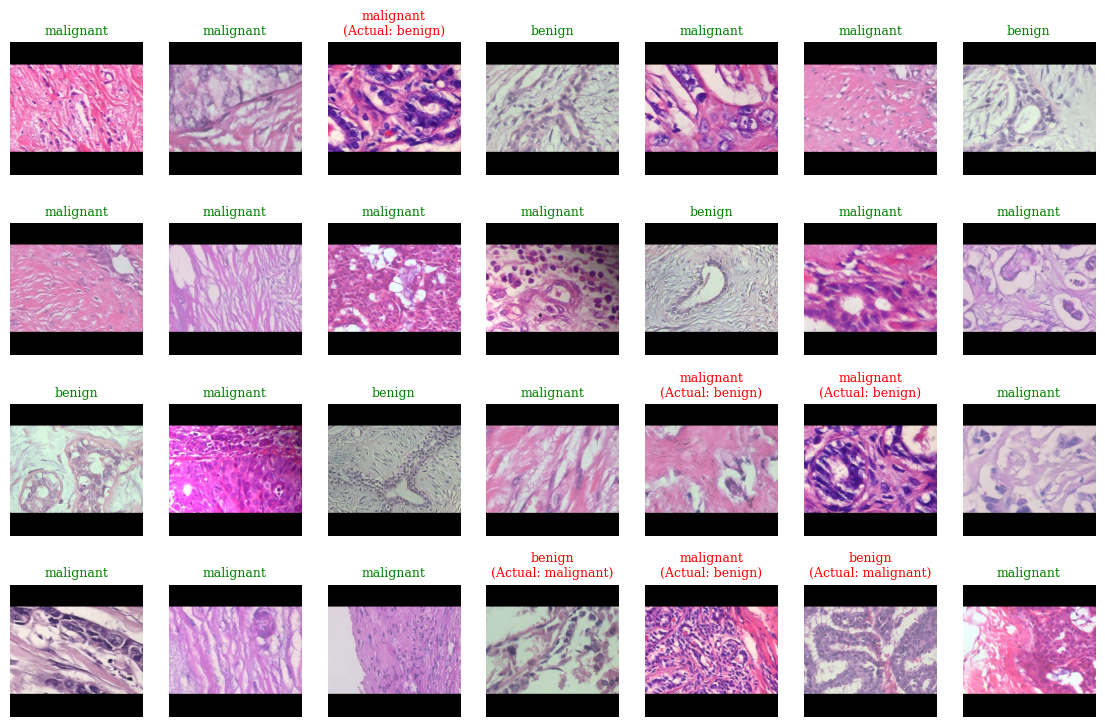

In [25]:
plot_predictions(custom_model)

# Transfer Learning

[Transfer learning][trans-learn] is the practice of applying knowledge acquired from one task to another related task. It is widely used in computer vision problems to obtain high performance with little data, by leveraging pre-trained models that have learnt how to extract features from massive collections of images (most commonly the [ImageNet][imagenet] database).

Let's see how some of the most popular model architectures perform on this dataset:

[trans-learn]: https://en.wikipedia.org/wiki/Transfer_learning
[imagenet]: https://www.image-net.org/


## Model with MobileNetV3 base

MobileNetV3 paper: <https://arxiv.org/abs/1905.02244>

In [ ]:
pretrained_mobnet_base = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_mobnet_base.trainable = False

mobnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # MobileNet
    layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input),
    pretrained_mobnet_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="MobileNetV3")
mobnet_model.summary()

In [ ]:
mobnet_history = compile_and_fit_model(mobnet_model)

In [ ]:
evaluate_model(mobnet_model)

There are a lot of *false positives (190)*. Many healthy women would get a false alarm.

In [ ]:
plot_predictions(mobnet_model)

## Model with EfficientNetB1 base

EfficientNet paper: <https://arxiv.org/abs/1905.11946>

In [ ]:
pretrained_efficientnet_base = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_efficientnet_base.trainable = False

efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # EfficientNet
    pretrained_efficientnet_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="EfficientNetB1")
efficientnet_model.summary()

In [ ]:
efficientnet_history = compile_and_fit_model(efficientnet_model)

In [ ]:
evaluate_model(efficientnet_model)

This model is very promising. It has attained the highest test ROC-AUC score so far. But the number of *false positives (120)* is a concern. There is room for improvement.

In [ ]:
plot_predictions(efficientnet_model)

## Model with VGG16 base

VGG paper: <https://arxiv.org/abs/1409.1556>

In [ ]:
pretrained_vgg16_base = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_vgg16_base.trainable = False

vgg16_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # VGG16
    layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
    pretrained_vgg16_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(384, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="VGG16")
vgg16_model.summary()

In [ ]:
vgg16_history = compile_and_fit_model(vgg16_model)

In [ ]:
evaluate_model(vgg16_model)

So many *false negatives (107)*. A lot of breast cancer cases could go undetected.

In [ ]:
plot_predictions(vgg16_model)

## Model with ResNet50V2 base

ResNetV2 paper: <https://arxiv.org/abs/1603.05027>

In [ ]:
pretrained_resnet_base = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_resnet_base.trainable = False

resnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # ResNet
    layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input),
    pretrained_resnet_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="ResNet50V2")
resnet_model.summary()

In [ ]:
resnet_history = compile_and_fit_model(resnet_model)

In [ ]:
evaluate_model(resnet_model)

An even larger amount of *false negatives (140)*. So many patients requiring medical attention would be deceived that they are well.

In [ ]:
plot_predictions(resnet_model)

# Model Evaluation

The EfficientNetB1 model achieved the least loss (0.386096) and highest ROC-AUC score (0.876673) on the test dataset.

The custom CNN model attained the highest accuracy score (0.854656).

In [ ]:
fitted_models = [custom_model, mobnet_model, efficientnet_model, vgg16_model,
                 resnet_model]
test_metrics = pd.DataFrame(
    {model.name: model.evaluate(test_ds, verbose=0) for model in fitted_models},
    index=["Loss", "ROC-AUC", "Accuracy"]
)
test_metrics.style.highlight_min(color="gold", axis=None)\
                  .highlight_max(color="lawngreen", axis=None)

In [ ]:
# Process training metrics
hist_list = [custom_history, mobnet_history, efficientnet_history,
             vgg16_history, resnet_history]
train_metrics = pd.concat([pd.DataFrame(hist.history) for hist in hist_list],
                          axis=1, keys=[hist.model.name for hist in hist_list])
train_metrics.head()
color_dict = dict(zip(test_metrics, plt.colormaps["Set2"].colors))

# Plot training and test metrics
fig, axes = plt.subplot_mosaic("\naab\nccd\neef\n", figsize=(11, 11),
                               dpi=180, tight_layout=True)
for ax, metric in zip([axes["a"], axes["c"], axes["e"]],
                      ["val_roc_auc", "val_binary_accuracy", "val_loss"]):
    data_ = train_metrics.filter(like=metric)
    data_.plot(ax=ax, lw=3, color=[color_dict[col]
                                   for col in data_.columns.levels[0]])
    ax.set_xlabel("Epochs", size=11)

for ax, metric in zip([axes["b"], axes["d"], axes["f"]],
                      ["ROC-AUC", "Accuracy", "Loss"]):
    data_ = test_metrics.loc[metric].sort_values()
    data_.plot.barh(ax=ax, color=[color_dict[col] for col in data_.index])
    ax.bar_label(ax.containers[0], [f"{x:.5f}" for x in ax.containers[0].datavalues])
    ax.bar_label(ax.containers[0], data_.index, label_type="center")
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.spines["bottom"].set_visible(False)

titles = ["Training ROC-AUC", "Test ROC-AUC", "Training Accuracy", "Test Accuracy",
          "Training Loss", "Test Loss"]
for ax, title in zip(axes.values(), titles):
    ax.set_title(title, size=16, loc="left")

axes["a"].legend(title="")
axes["c"].legend(title="")
axes["e"].legend(title="");

# Ensemble

> _"The whole is greater than the sum of its parts."_ - Aristotle

Machine learning models can be combined into a composite model that is often better than any individual model. This is referred to as [Ensembling][ensemble].

Common ensembling techniques include:

1. **Bagging:** Fitting several "whole/full" models on subsets of the data (and even subsets of the features), then aggregating their results e.g. A Random-forest consists of several decision tree models.
2. **Boosting:** Starts with a "weak/shallow" model, then successively adds weak models focused on portions of the data that the overall model is performing poorly on e.g. a Gradient-boosting model consists of several shallow decision tree models.
3. **Stacking:** Using predictions from several models as inputs to a final estimator.

Let's investigate if [stacking][stacking] can improve the results:

(Thanks [@Tilii for suggesting this][comment])

[ensemble]: https://en.wikipedia.org/wiki/Ensemble_learning
[stacking]: https://en.wikipedia.org/wiki/Ensemble_learning#Stacking
[comment]: https://www.kaggle.com/code/timothyabwao/detecting-breast-cancer-with-computer-vision/comments#2188846

In [ ]:
def get_predictions_and_labels(dataset: tf.data.Dataset) -> Tuple:
    # Get labels and predictions for each batch in dataset
    results = [(labels, [model.predict(images, verbose=0).reshape(-1,)
                         for model in fitted_models])
               for images, labels in dataset.take(-1)]
    labels = np.concatenate([x[0] for x in results])
    # Combine predictions, then transpose to shape (nsamples, nmodels)
    preds = np.concatenate([x[1] for x in results], axis=1).transpose()
    return preds, labels


train_preds, train_labels = get_predictions_and_labels(train_ds)
valid_preds, valid_labels = get_predictions_and_labels(validation_ds)
test_preds, test_labels = get_predictions_and_labels(test_ds)

In [ ]:
stacking_model = LogisticRegressionCV(scoring="roc_auc")
stacking_model.fit(train_preds, train_labels)
stacked_preds = stacking_model.predict_proba(test_preds)

test_metrics["Stacking Ensemble"] = [
    metrics.log_loss(test_labels, stacked_preds),
    metrics.roc_auc_score(test_labels,
                          stacked_preds[:, 1]), # get stacked +ve probability
    metrics.accuracy_score(test_labels,
                           stacked_preds.argmax(axis=1)) # get stacked predicted label
]
test_metrics.style.highlight_min(color="gold", axis=None)\
                  .highlight_max(color="lawngreen", axis=None)

The stacked ensemble significantly improves the test ROC-AUC score, but the EfficientNetB1 model still yields the least loss.

In [ ]:
# Store models for deployment
custom_model.save("custom_cnn.h5")
mobnet_model.save("mobnetv3sm.h5")
efficientnet_model.save("efficientnetv2B1.h5")
vgg16_model.save("vgg16.h5")
resnet_model.save("resnet50v2.h5")

!du -h *.h5  # view file size

# Deployment Options

A number of deployment strategies are discussed in this insightful video:

<iframe width="560" height="315" src="https://www.youtube.com/embed/W3hKjXg7fXM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

I plan to explore the "Model as a Service" and "REST API" architectures. In the meantime, here is a [prototype predictor web-app][stapp] ("model in server").

[stapp]: https://github.com/Tim-Abwao/detecting-breast-cancer

## Acknowledgements

This effort is part of the [KaggleX BIPOC Mentorship Program][bipoc]. Many thanks to my mentor [Ghulam Jillani][jillani] for key pointers on model architectures.

[bipoc]: https://www.kaggle.com/kagglex-bipoc-mentorship-program/
[jillani]: https://www.kaggle.com/jillanisofttech